# Lab 7: Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"L7_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before 23:59 on December 5, 2018 and put **"AML-L7"** in the subject. 

We begin with the standard imports:

In [3]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## NMF

Non-negative Matrix Factorization is a model where a matrix V is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.

Fill in the following class that implements a NMF by multiplicative updates using the Frobenius norm or the Kullback-Leiber divergence as loss function (implement both), you can add more methods if needed. Try 10 different random initializations and choose the best one.

In [4]:
class my_NMF():
    
    def __init__(self, n_components, loss='Frobenius', epsilon=1e-4, max_iter = 300):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_: float
            convergence
        loss_ = {"Frobenius", "KL"}
        W_: np.array (r,p)
            W Matrix factor
        H_: np.array (n,r)
            H Matrix factor
        '''
        self.n_components_ = n_components
        self.max_iter_ = max_iter
        self.loss_ = loss
        self.epsilon_ = epsilon
        self.W_ = None
        self.H_ = None
        self.history_ = None
        
    def update_W(self, W, H, X):
        """
        
        """
        n = X.shape[0]
        p = X.shape[1]
        r = self.n_components_
        
        if self.loss_=="Frobenius":
            return np.multiply(W, np.divide(H.T@X,H.T@H@W + 1e-7))
            
        elif self.loss_=="KL":
            return np.multiply(np.divide(H.T@np.divide(X, H@W + 1e-7), H.T@np.ones((n,p))), W)
            
        else:
            raise ValueError
        
    def update_H(self, W, H, X):
        """
        
        """
        n = X.shape[0]
        p = X.shape[1]
        r = self.n_components_
        
        if self.loss_=="Frobenius":
            return np.multiply(H, np.divide(X@W.T,H@W@W.T + 1e-7))
            
        elif self.loss_=="KL":
            return np.multiply(np.divide(np.divide(X, H@W)@W.T, np.ones((n,p))@W.T + 1e-7), H)
            
        else:
            raise ValueError
            
    def compute_loss(self, W, H, X):
        """
        
        """
        if self.loss_=="Frobenius":
            return np.linalg.norm(X-H@W, ord='fro')
            
        elif self.loss_=="KL":
            return np.sum(sc.special.kl_div(X,H@W))
            
        else:
            raise ValueError
        
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        n = X.shape[0]
        p = X.shape[1]
        r = self.n_components_

        self.W_ = np.random.rand(r, p)
        self.H_ = np.random.rand(n, r)
        self.error_ = self.compute_loss(self.W_, self.H_, X)
        self.history_ = {
            "W": [self.W_],
            "H": [self.H_],
            "error": [self.error_],
            "converged": False,
            "itr": None
        }

        has_converged = False
        itr = 0
        while not has_converged and itr < self.max_iter_:
            W = self.update_W(self.W_, self.H_, X)
            H = self.update_H(W, self.H_, X)
            
            error = self.compute_loss(W, H, X)
            
            has_converged = abs(error-self.error_) / self.error_ < self.epsilon_
            
            self.W_, self.H_, self.error_ = W, H, error
            
            self.history_["W"].append(W)
            self.history_["H"].append(H)
            self.history_["error"].append(error)
            
            itr += 1
        
        self.history_["converged"] = has_converged
        self.history_["itr"] = itr
        
        return self

---

## Applications

### First application

For the first application we are going to analyse the following data to give an interpretation of the factorization:

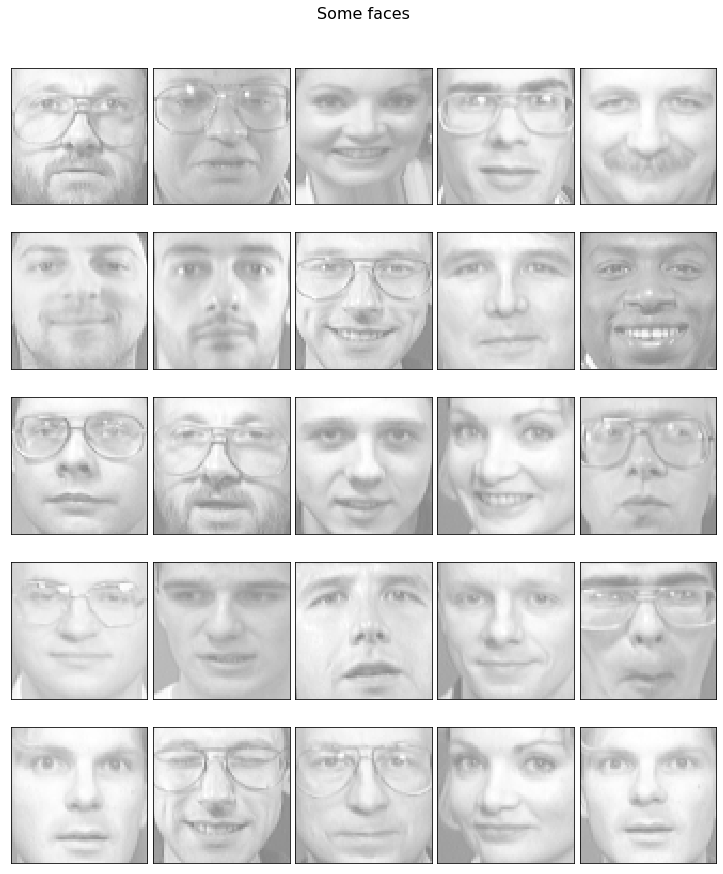

In [16]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
image_shape = (64, 64)

n_samples, n_features = faces.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray, h=2., w=2.6):
    plt.figure(figsize=(h * n_col, w * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces[:25], image_shape)

We apply our NMF algorithm for this dataset and plot the approximated face pictures.

In [17]:
r = 49

# NMF using Frobenius norm
model_f = my_NMF(n_components=r, loss='Frobenius', epsilon=1e-6, max_iter = 500)
model_f.fit_transform(faces)
h_f = model_f.history_

# NMF using KL divergence
model_kl = my_NMF(n_components=r, loss='KL', epsilon=1e-6, max_iter = 500)
model_kl.fit_transform(faces)
h_kl = model_kl.history_

###### Visualizing a face and its deconstruction or representation

- Plot the $W$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid

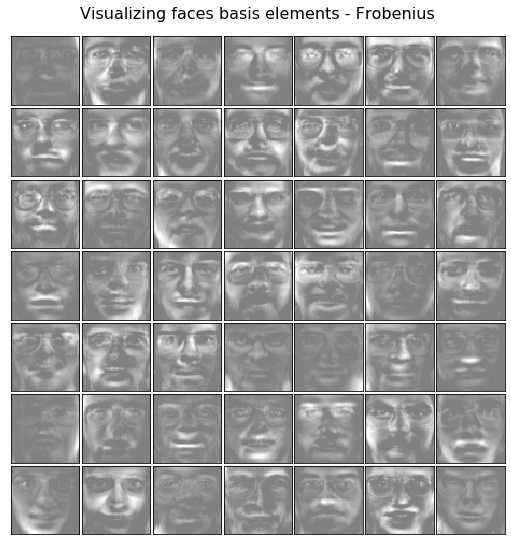

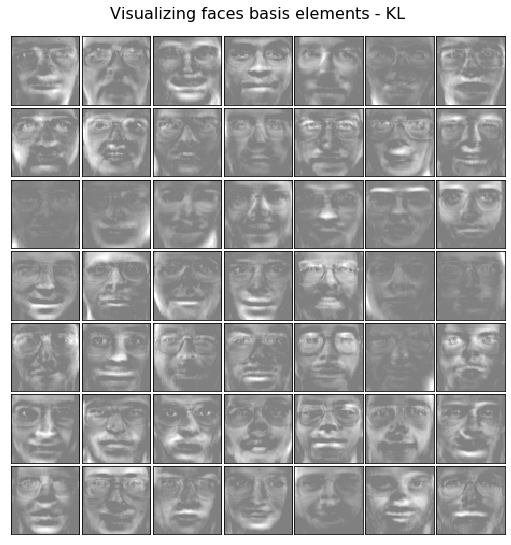

In [18]:
W_f = model_f.W_
W_kl = model_kl.W_
sqrt_r = int(np.sqrt(r))

plot_faces("Visualizing faces basis elements - Frobenius", W_f, image_shape, n_col=sqrt_r, n_row=sqrt_r,
          h=1, w=1.13)
plot_faces("Visualizing faces basis elements - KL", W_kl, image_shape, n_col=sqrt_r, n_row=sqrt_r,
          h=1, w=1.13)

- Choose one face, plot its corresponding weights (in $H$) in a grid  and explain the interpretation of both factor matrices.

In [19]:
def get_approx(model, index):
    return model.H_[index]@model.W_

def get_weights(model, index):
    return model.H_[index,:]

Select a random face :

In [20]:
index = np.random.randint(faces.shape[0])

**Using the frobenius norm**

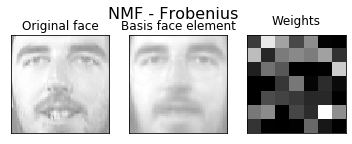

Error (Frobenius) between Orginal Face and its Approximation: 3.487


In [21]:
plt.figure(figsize=(2. * 3, 2.26 * 1))
plt.suptitle('NMF - Frobenius', size=16)
cmap=plt.cm.gray

### Plot the original image
plt.subplot(1, 3, 1)
original = faces[index]
vmax = max(original.max(), -original.min())
plt.imshow(original.reshape(image_shape), cmap=cmap,
           interpolation='nearest',
           vmin=-vmax, vmax=vmax)
plt.title("Original face")
plt.xticks(())
plt.yticks(())


### Plot the reconstructed image
plt.subplot(1, 3, 2)
approx = get_approx(model_f, index)
vmax = max(original.max(), -original.min())
plt.imshow(approx.reshape(image_shape), cmap=cmap,
           interpolation='nearest',
           vmin=-vmax, vmax=vmax)
plt.title("Basis face element")
plt.xticks(())
plt.yticks(())


### Plot the weights corresponding to this image
ax = plt.subplot(1, 3, 3)
ax.matshow(get_weights(model_f, index).reshape(sqrt_r, sqrt_r), cmap=cmap)
plt.title("Weights")
plt.xticks(())
plt.yticks(())


plt.show()

print("Error (Frobenius) between Orginal Face and its Approximation: {:.3f}"
      .format(np.linalg.norm(x=original.reshape(image_shape) - approx.reshape(image_shape),
                             ord="fro")))

**Using the KL divergence**

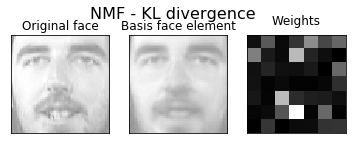

KL divergence between Orginal Face and its Approximation: 10.963


In [36]:
plt.figure(figsize=(2. * 3, 2.26 * 1))
plt.suptitle('NMF - KL divergence', size=16)
cmap=plt.cm.gray
plt.subplot(1, 3, 1)
original = faces[index]
vmax = max(original.max(), -original.min())
plt.imshow(original.reshape(image_shape), cmap=cmap,
           interpolation='nearest',
           vmin=-vmax, vmax=vmax)
plt.title("Original face")
plt.xticks(())
plt.yticks(())

plt.subplot(1, 3, 2)
approx = get_approx(model_kl, index)
vmax = max(approx.max(), -approx.min())
plt.imshow(approx.reshape(image_shape), cmap=cmap,
           interpolation='nearest',
           vmin=-vmax, vmax=vmax)
plt.title("Basis face element")
plt.xticks(())
plt.yticks(())

ax = plt.subplot(1, 3, 3)
ax.matshow(get_weights(model_kl, index).reshape(sqrt_r, sqrt_r), cmap=cmap)
plt.title("Weights")
plt.xticks(())
plt.yticks(())


plt.show()

print("KL divergence between Orginal Face and its Approximation: {:.3f}"
      .format(np.sum(sc.special.kl_div(original.reshape(image_shape), approx.reshape(image_shape)))))

>Using Frobenius yields better results that using the KL divergence.

Interpretation of the weights :

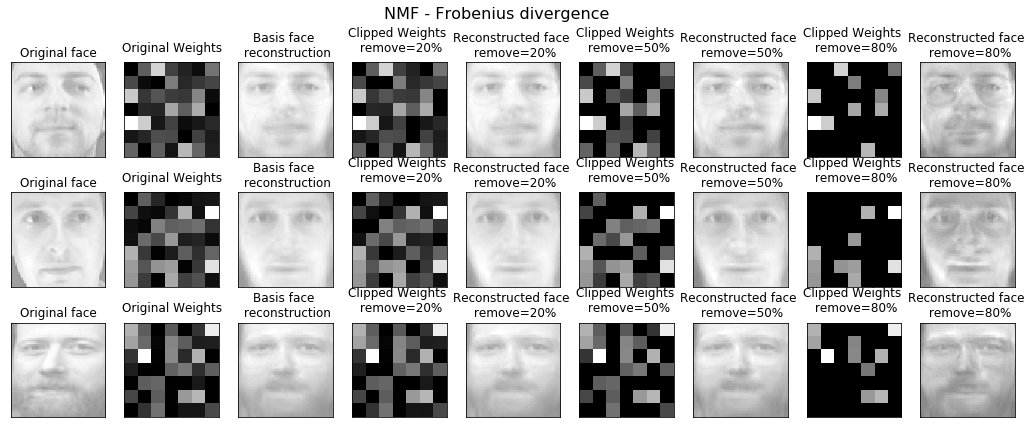

In [42]:
index1 = np.random.randint(faces.shape[0])
index2 = np.random.randint(faces.shape[0])
index3 = np.random.randint(faces.shape[0])
indexes = [index1,index2,index3]

percentages = [20,50,80]
nb_indexes = len(indexes)
total = len(percentages)*2 + 3

plt.figure(figsize=(2. * total, 2.26 * nb_indexes))
plt.suptitle('NMF - Frobenius divergence', size=16)
cmap=plt.cm.gray
for rank, idx in enumerate(indexes):
    w_idx = get_weights(model_f, idx)
    
    ### Plot the original image
    plt.subplot(nb_indexes, total, rank*total+1)
    original = faces[idx]
    vmax = max(original.max(), -original.min())
    plt.imshow(original.reshape(image_shape), cmap=cmap,
               interpolation='nearest',
               vmin=-vmax, vmax=vmax)
    plt.title("Original face")
    plt.xticks(())
    plt.yticks(())
    
    ### Plot the original weights
    ax = plt.subplot(nb_indexes, total, rank*total+2)
    ax.matshow(w_idx.reshape(sqrt_r, sqrt_r), cmap=cmap)
    plt.title("Original Weights")
    plt.xticks(())
    plt.yticks(())

    ### Plot the restored image with full weights
    plt.subplot(nb_indexes, total, rank*total+3)
    full_rec = w_idx@model_f.W_
    vmax = max(full_rec.max(), -full_rec.min())
    plt.imshow(full_rec.reshape(image_shape), cmap=cmap,
               interpolation='nearest',
               vmin=-vmax, vmax=vmax)
    plt.title("Basis face \n reconstruction")
    plt.xticks(())
    plt.yticks(())
    
    for step, lvl in enumerate(percentages):
        thresh = np.percentile(w_idx, lvl)
        w_idx_clip = (w_idx > thresh).astype('int')*w_idx
        reconstructed = w_idx_clip@model_f.W_
        
        ### Plot the corresponding restored image
        ax = plt.subplot(nb_indexes, total, rank*total+4 + step*2)
        ax.matshow(w_idx_clip.reshape(sqrt_r, sqrt_r), cmap=cmap)
        plt.title("Clipped Weights \n remove={}%".format(lvl))
        plt.xticks(())
        plt.yticks(())
        
        ### Plot the highest weights corresponding to lvl
        plt.subplot(nb_indexes, total, rank*total+5 + step*2)
        vmax = max(reconstructed.max(), -reconstructed.min())
        plt.imshow(reconstructed.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.title("Reconstructed face \n remove={}%".format(lvl))
        plt.xticks(())
        plt.yticks(())

plt.show()

>We visualize the reconstruction when removing a certain percentage of the weights. Each weight correspond to a different feature : when removing some we observe that the reconstruction is less exact. 

---

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with NMF. Print the most common words of each topic.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

bunch = fetch_20newsgroups(subset="all", remove=("header", "footer", "quotes"))
texts = bunch.data

Extract features from the sentence using sklearn, vectorizing it to make it usable :

In [43]:
tfidf = TfidfVectorizer(stop_words="english", input="content", analyzer="word")
data = tfidf.fit_transform(texts)
print('The shape of the dataset is then :', data.shape)

The shape of the dataset is then : (18846, 160536)


In [44]:
indexes = np.random.randint(0, data.shape[0], 2000)
sampled_data = data[indexes]
print('We select a subsample of the dataset of shape :', sampled_data.shape)

We select a subsample of the dataset of shape : (2000, 160536)


Then we use our method to extract most important words to represent the sentence :

In [12]:
r = 20
model = my_NMF(n_components=r, loss='Frobenius', epsilon=1e-6, max_iter = 100)
model.fit_transform(sampled_data.A)

In [14]:
vec2voc = {v: k for k, v in tfidf.vocabulary_.items()}

In [45]:
n_words = 15
W = model.W_ 
for idx, topic in enumerate(W):
    print("TOPIC #{} -------------------".format(idx))
    most_common_words = np.argpartition(-topic, n_words)[:n_words]
    print('Most common words are :',*[vec2voc[w] for w in most_common_words])
    print()

TOPIC #0 -------------------
Most common words are : dos windows os microsoft font files run screen ms window fonts file ini application win

TOPIC #1 -------------------
Most common words are : cam mit cramer uk liv mcc mathew optilink wed ac mantis csc 93 apr expo

TOPIC #2 -------------------
Most common words are : livesey com sgi solntze wpd jon ibm nntp stratus posting sun host subject organization lines

TOPIC #3 -------------------
Most common words are : case western reserve cleveland ins cwru edu tony hela po usa freenet oh alicea ch981

TOPIC #4 -------------------
Most common words are : 50 20 95 sale 00 mollica ralf 25 10 shipping 11 disks xv price drive

TOPIC #5 -------------------
Most common words are : cc cunixa sebastian edu gld columbia r100s sears dare gary scs8 cunixb nyc bmw xs750f

TOPIC #6 -------------------
Most common words are : mayans televison phil srl02 fraering southwestern pgf repo cacs usl louisiana sorts like stuff ancient

TOPIC #7 -----------------